# Melanoma Detection Assignment
```
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.
```

### Importing Skin Cancer Data

### Importing all the important libraries

In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import Augmentor
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# disabling tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [9]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path('./Test')

In [10]:
# counting total images in train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
# defining batch_size, image height and width
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## Train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

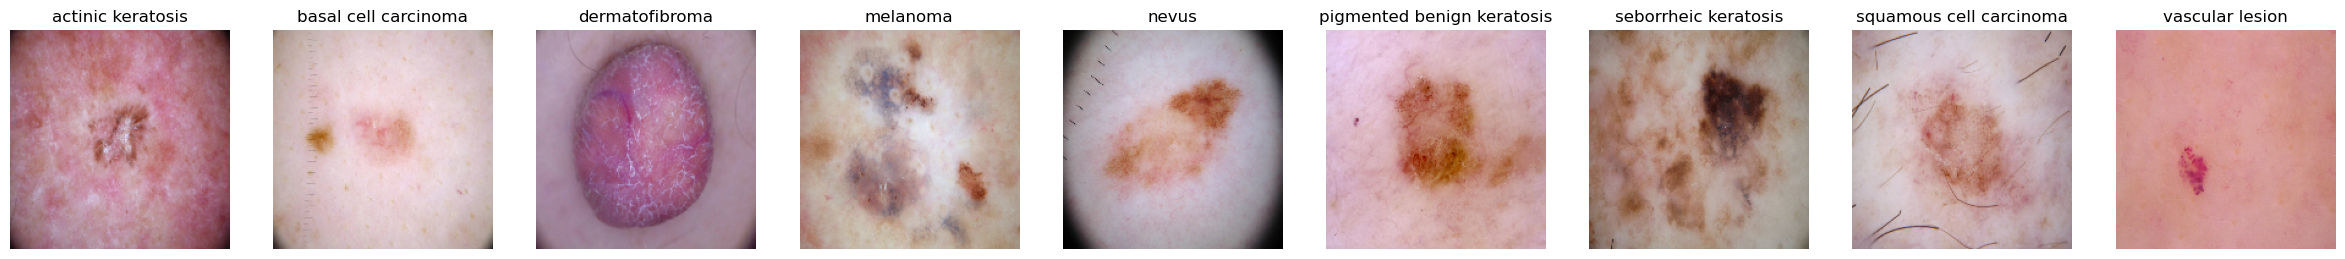

In [15]:
### using validation data to visualize
plt.figure(figsize=(30, 30))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(1, 9, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
# Initial model
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
# Using adam optimiser and sparse categorical cross entropy as the loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 78ms/step - loss: 1.9912 - accuracy: 0.2651 - val_loss: 1.8706 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6637 - accuracy: 0.4057 - val_loss: 1.4679 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4375 - accuracy: 0.5100 - val_loss: 1.4051 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4052 - accuracy: 0.5028 - val_loss: 1.4869 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3419 - accuracy: 0.5218 - val_loss: 1.3543 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2751 - accuracy: 0.5474 - val_loss: 1.4094 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1854 - accuracy: 0.5831 - val_loss: 1.3792 - val_accuracy: 0.5145
Epoch 8/20
5

### Visualizing training results

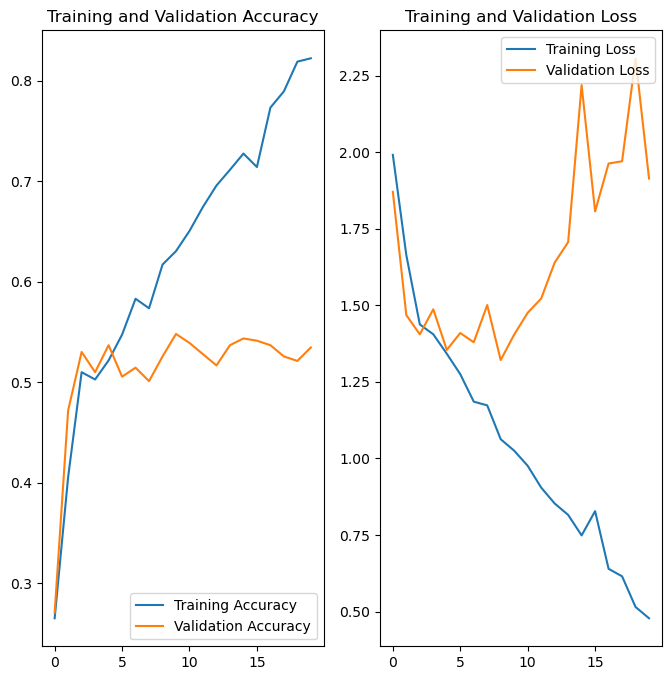

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfitting
From the above plots, it is clear that the model is overfitting on data.
- Training loss drops with each epoch while the validation loss starts to increase after 5 epochs.
- The training accuracy keeps climbing with each epoc while the validation accuracy stays between 0.5 and 0.6.

### Fixing Model Overfit

In [22]:
# Data augumentation strategy. 
# Using tf.device due to gpu bug with tensorflow-macos
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

/tmp/ipykernel_28/3339223685.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 9, i + 1)


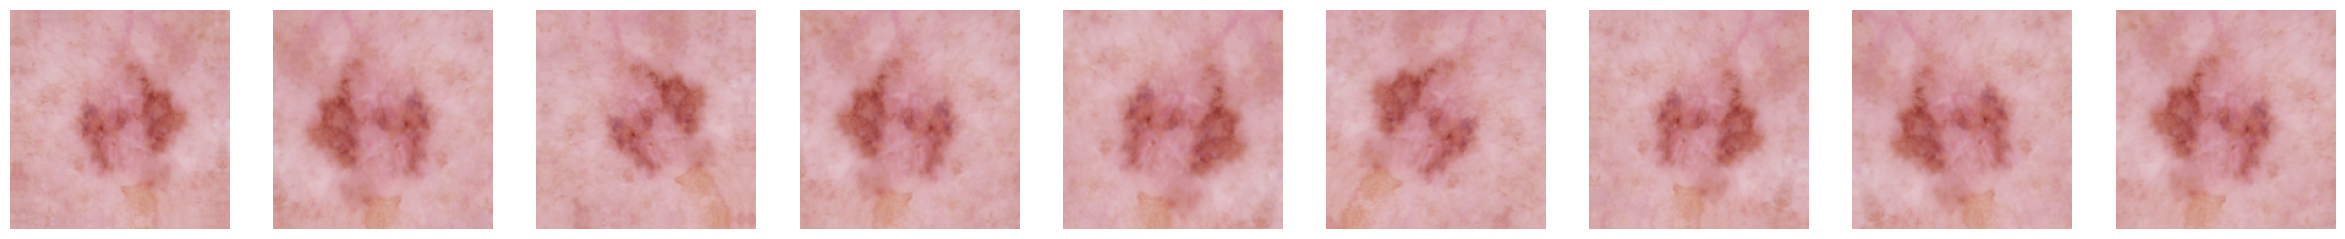

In [23]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(30, 10))
plt.title("Single Image being augmented")
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 9, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [24]:
## Adding data augmentation and Dropout as there is an evidence of overfitting

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

### Compiling the model

In [25]:
# Using adam optimiser and sparse categorical cross entropy as the loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-08-08 03:05:02.781885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 4s 32ms/step - loss: 2.1458 - accuracy: 0.2054 - val_loss: 2.0120 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8198 - accuracy: 0.3359 - val_loss: 1.6274 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6021 - accuracy: 0.4319 - val_loss: 1.5004 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5059 - accuracy: 0.4648 - val_loss: 1.4509 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3986 - accuracy: 0.4961 - val_loss: 1.5012 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4455 - accuracy: 0.4844 - val_loss: 1.3551 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3197 - accuracy: 0.5229 - val_loss: 1.3591 - val_accuracy: 0.5503
Epoch 8/20
56/56 [======

### Visualizing the results

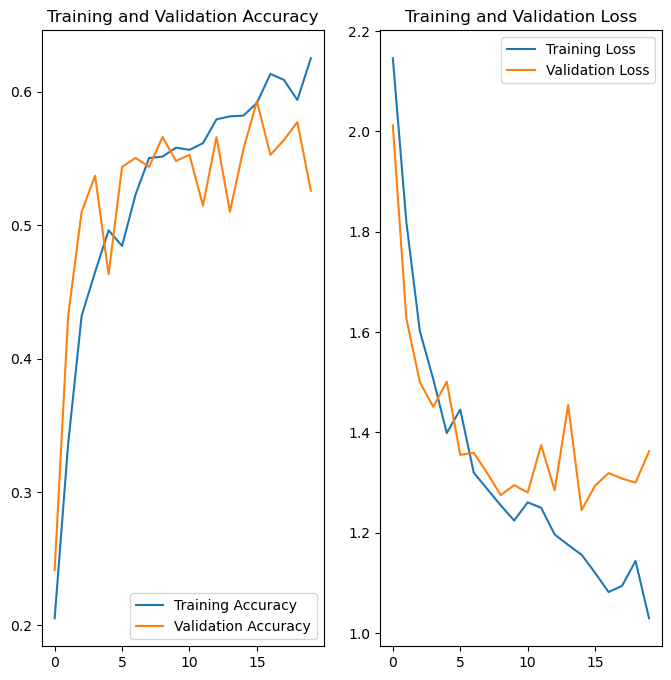

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Do you think there is some improvement now as compared to the previous model run?
We had fixed model overfitting as there is less difference between training & validation loss and accuracy. But the model performace is still not good. We have reached around 55% accuracy. 

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

actinic keratosis : 114
basal cell carcinoma : 376
dermatofibroma : 95
melanoma : 438
nevus : 357
pigmented benign keratosis : 462
seborrheic keratosis : 77
squamous cell carcinoma : 181
vascular lesion : 139


<BarContainer object of 9 artists>

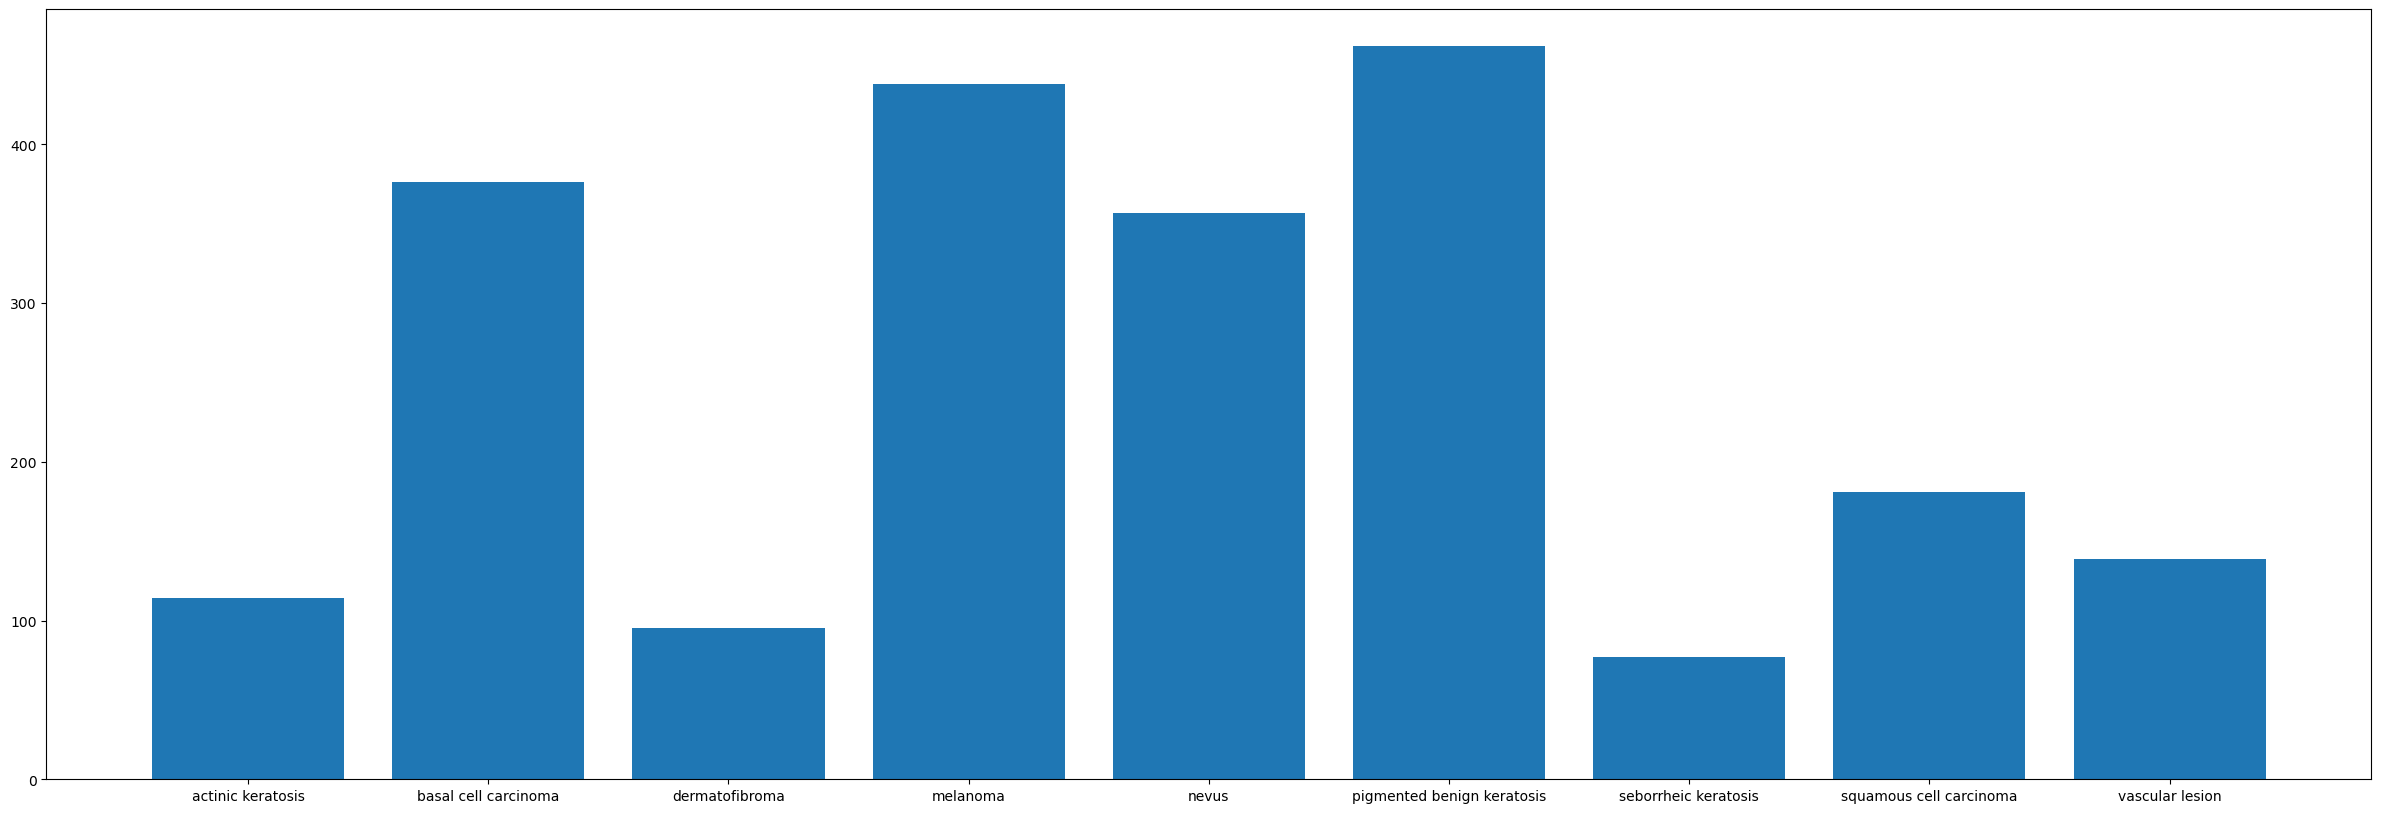

In [28]:
distribution = list(map((lambda class_name: len(list(data_dir_train.glob(class_name + '/*.jpg')))), class_names))

for class_name, count in zip(class_names,distribution):
    print(class_name, count, sep=' : ')

plt.figure(figsize=(30,10))
plt.bar(class_names,distribution)

#### - Which class has the least number of samples?
seborrheic keratosis has the least number of samples at just 77
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis, melanoma, basal cell carcinoma and nevus dominates the data in terms of proportionate number of sample.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
current_path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("current_path_list: ",len(current_path_list))
current_lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("lesion_list: ",len(current_lesion_list))
current_dataframe_dict = dict(zip(current_path_list, current_lesion_list))
current_df=pd.DataFrame(list(current_dataframe_dict.items()),columns=['Path','Label'])

current_path_list:  2239
lesion_list:  2239


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="./Train"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C3A315BEFE0>: 100%|██████████| 500/500 [00:12<00:00, 41.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3A315F3760>: 100%|██████████| 500/500 [00:12<00:00, 39.50 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3A3157FE50>: 100%|██████████| 500/500 [00:13<00:00, 37.73 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7C3A317F2620>: 100%|██████████| 500/500 [01:07<00:00,  7.44 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7C3A3C52ED70>: 100%|██████████| 500/500 [01:07<00:00,  7.44 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3A3157D600>: 100%|██████████| 500/500 [00:12<00:00, 39.32 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C3A3C53CA30>: 100%|██████████| 500/500 [00:32<00:00, 15.21 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3A3C52F0A0>: 100%|██████████| 500/500 [00:12<00:00, 40.40 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3A3C53C1F0>: 100%|██████████| 500/500 [00:12<00:00, 39.02 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = current_df.append(df_new)

/tmp/ipykernel_28/1035665993.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = current_df.append(df_new)


In [35]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Create a training dataset

In [36]:
data_dir_train="./Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (includes normalization)

In [38]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [39]:
# Using adam optimiser and sparse categorical cross entropy as the loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Train your model

In [40]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2023-08-08 03:11:40.911876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


169/169 [==============================] - 30s 157ms/step - loss: 1.9050 - accuracy: 0.2730 - val_loss: 1.7475 - val_accuracy: 0.3489
Epoch 2/30
169/169 [==============================] - 28s 158ms/step - loss: 1.5185 - accuracy: 0.4240 - val_loss: 1.4352 - val_accuracy: 0.4529
Epoch 3/30
169/169 [==============================] - 27s 157ms/step - loss: 1.4223 - accuracy: 0.4501 - val_loss: 1.3884 - val_accuracy: 0.4736
Epoch 4/30
169/169 [==============================] - 27s 156ms/step - loss: 1.3431 - accuracy: 0.4828 - val_loss: 1.2774 - val_accuracy: 0.5271
Epoch 5/30
169/169 [==============================] - 28s 158ms/step - loss: 1.2545 - accuracy: 0.5256 - val_loss: 1.3026 - val_accuracy: 0.5249
Epoch 6/30
169/169 [==============================] - 28s 159ms/step - loss: 1.2205 - accuracy: 0.5328 - val_loss: 1.1769 - val_accuracy: 0.5590
Epoch 7/30
169/169 [==============================] - 27s 153ms/step - loss: 1.1658 - accuracy: 0.5592 - val_loss: 1.1318 - val_accuracy: 0.5

#### Visualize the model results

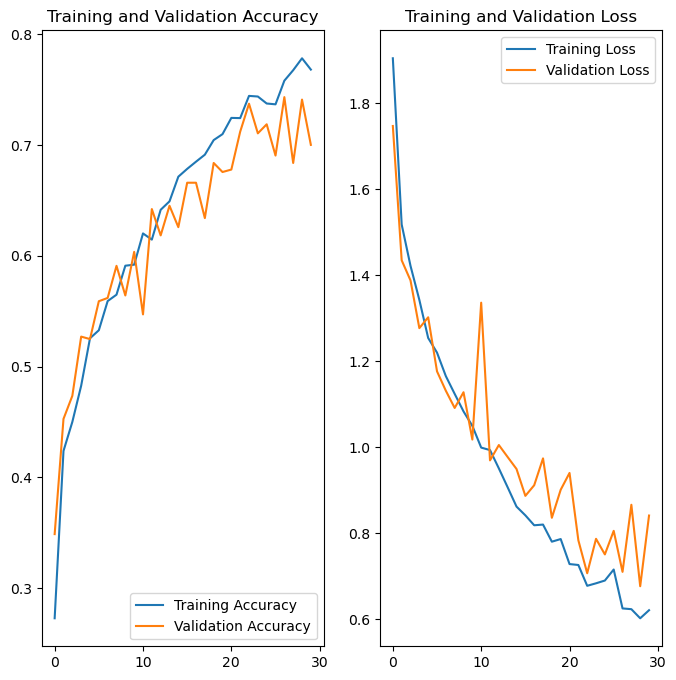

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
- We have fixed the problem of overfitting as the train and validation loss/accuracy are not far apart.
  Our training accuracy is ~76% and our validation accuracy is ~70%
- Class Rebalancing using Augmentor helped increase the accuracy of the model. Our previous model had only ~60% accuracy. Augmentor helped increase our accuracy by more than 10%.